# Clear Sky Composite of Goes-16 Images

## Step 1: Setting work environment

Importing libraries

In [11]:
import calendar, datetime, os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from PIL import Image
import matplotlib.image as mpimg
from matplotlib import cm
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import matplotlib.image as mpimg
import random
from sewar.full_ref import mse, vifp

Input/output path and locations/period of interest

In [ ]:
# Input: path where the files with .nc extension are located
path_input = " "

# Output 1: path where the cropped .nc files will be saved
path_output_1 = " "

# Output 2: path where the composite files with .nc extensions will be saved
path_output_2 =  " "

# Output 3: path where the clear sky images will be saved
path_output_3 = " "

# Year and months of interest
# IMPORTANT: months must be in the string format, in the 01-12 range
year = 2019
months = ['01', '04', '07', '10']

# Locations: list with names, latitudes and longitudes of the areas of interest
locations = [['brb', -15.60083, -47.71306],
             ['cpa', -22.6896, -45.0062],
             ['ptr', -9.0689, -40.3197],
             ['sms', -29.4428, -53.8231]]

## Part 2: cropping NetCDF files

In [ ]:
# Setting file paths where the .nc files are located
directory = os.fsencode(path_input)
os.chdir(path_input)

# Looping through the selected months
for month in months:
    
    # Setting start and end date in julian day format
    day_start = calendar.monthrange(year, int(month))[0]
    day_end = calendar.monthrange(year, int(month))[1]

    julian_start = datetime.datetime.strptime(month + '.' + str(day_start), '%m.%d').timetuple().tm_yday
    julian_end = datetime.datetime.strptime(month + '.' + str(day_end), '%m.%d').timetuple().tm_yday

    # Creating list with range of julian days which will be further used to locate the respective files
    days = []

    for day in range(julian_start, julian_end + 1):
        if day < 10:
            days.append('00' + str(day))
        elif day < 100:
            days.append('0' + str(day))
        else:
            days.append(str(day))
    
    # Looping through locations
    for location in locations:
        
        # Looping through the files 
        for file in os.listdir(directory):
            
            file = file.decode('utf-8')
            
            # Matching the file with the desired month
            if file[-13:-10] in days:
                ds = xr.open_dataset(file)

                # Extracting the date from the file
                date = str(ds.attrs['date_created'])

                # Selecting the variables
                lon = ds['lon'].values
                lat = ds['lat'].values

                # Setting the value of k, this is the size of our box around the location
                k = 2.0

                # Setting the latitude and latitude
                lat_station = location[1]
                lon_station = location[2]
                lat_list = list(lat)
                lon_list = list(lon)

                # Finding the closest point in the dataset that matches our location latitude and longitude
                lat_start = lat_list.index(lat_list[min(range(len(lat_list)), key = lambda i: abs(lat_list[i]-(lat_station - k)))])
                lat_end = lat_list.index(lat_list[min(range(len(lat_list)), key = lambda i: abs(lat_list[i]-(lat_station + k)))])
                lon_start = lon_list.index(lon_list[min(range(len(lon_list)), key = lambda i: abs(lon_list[i]-(lon_station - k)))])
                lon_end = lon_list.index(lon_list[min(range(len(lon_list)), key = lambda i: abs(lon_list[i]-(lon_station + k)))])

                # Setting the new .nc file with our specified dimensions
                data = ds['CMI'][lat_start:lat_end, lon_start:lon_end]

                # Naming our file with the date and time
                file = location[0] + '_' + date[0:4] + '_' + date[5:7] + '_' + date[8:10] + '_' + date[11:13] + date[14:16]

                # Saving the cropped NetCDF file
                data.to_netcdf(path=(path_output_1 + f'\{file}.nc'))
                ds.close()

## Part 3: creating composite image

In [ ]:
# Changing directory
directory = os.fsencode(path_output_1)
os.chdir(path_output_1)

# Looping through locations
for location in locations:
    
    # Looping through months
    for month in months:
        
        # Creating a list to store the different times of each image
        times = []

        # Looping through files in the folder
        for file in os.listdir(directory):

            file = file.decode('utf-8')

            # Matching the file name with the respective location and month
            if file[0:3] == location[0] and file[9:11] == month:

                if file[-7:-3] not in times:
                    times.append(file[-7:-3])

            #Looping through the times in the list
            for time in times:
                
                # Creating dummy array to kickstart the composite file
                ds1 = np.random.randint(1,5, size=(550,550))
                
                # Looping through the files in the folder
                for file in os.listdir(directory):
                    
                        # Opening the respective file that matches the time
                        if file.decode('utf-8')[0:3] == location[0] and file.decode('utf-8')[-7:-3] == time:
                            
                            # Opening the dataset
                            ds2 = xr.open_dataset(file.decode('utf-8'))
                            
                            # Vectorizing dataset
                            ds1_ = np.reshape(ds1, (1, 550*550))
                            ds2_ = np.reshape(ds2.CMI.values, (1, 550*550))
                            
                            # Getting minimum values between both datasets
                            ds3 = np.reshape(np.minimum(ds1_,ds2_), (550,550))
                            ds1 = ds3
                            ds2.close()

                # Creating new NetCDF file with minimum values           
                ds = xr.Dataset({"CMI": (("lat", "lon"), ds3)}, coords={"lat": ds2.lat.values,"lon": ds2.lon.values})
                
                # Setting file name and saving
                file = location[0]+ '_' + month + '_'+ time
                ds.to_netcdf(path=(path_output_2 + f'\{file}.nc'))
                
                # Resetting dummy dataset
                ds1 = np.random.randint(1,5, size=(550,550))

## Part 4: plotting the images

In [ ]:
# Changing directory
directory = os.fsencode(path_output_2)
os.chdir(path_output_2)

# Looping through locations
for location in locations:
    
    # Looping through files in folder
    for file in os.listdir(directory):
        
        # Opening dataset
        file = file.decode('utf-8')
        ds = xr.open_dataset(file)

        # Plotting the image
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        mapa = ds['CMI'].plot(ax=ax,transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False, cmap='gray', vmax=0.8, vmin=0)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(mapa, cax=cax).remove()
        gl = ax.grid(True)

        # Saving image
        file = file[0:-3] + '.png'
        plt.savefig(path_output_3 + f'\{file}')
        plt.close()
        ds.close()

## Part 5: creating compositions

In [ ]:
locations = ['brb', 'cpa', 'ptr', 'sms']

months = ['01', '04', '07', '10']

times = ['1300', '1310', '1320', '1330', '1340', '1350',
        '1400', '1410', '1420', '1430', '1440', '1450',
        '1500', '1510', '1520', '1530', '1540', '1550',
        '1600', '1610', '1620', '1630', '1640', '1650',
        '1700', '1710', '1720', '1730', '1740', '1750',
        '1800', '1810', '1820', '1830', '1840', '1850',
        '1900', '1910', '1920', '1930', '1940', '1950',
        '2000', '2010', '2020', '2030', '2040', '2050',]

time_arrays = []
time_keys = []
arrays = []

path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\recortadas'
directory = os.fsencode(path)
os.chdir(path)

location = 'brb'
month = '01'

for time in times:
    
    arrays = []
    
    for file in os.listdir(directory):
        file = file.decode('utf-8')
        if file[0:3] == location and file[9:11] == month and file[15:19] == time:
            ds = xr.open_dataset(file)
            arrays.append(ds.CMI.values)
            ds.close()
            
    if len(arrays) >= 25:
        time_keys.append(time)
        time_arrays.append(arrays)
        
data_dict = dict(zip(time_keys, time_arrays))

In [ ]:
path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\recortadas'
directory = os.fsencode(path)
os.chdir(path)

ds_ref = xr.open_dataset('brb_2019_01_01_0950.nc')


for key, value in data_dict.items():
    
    # Creating folder for netcdf files
    new_dir = key
    parent_dir = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}'
    path_new = os.path.join(parent_dir, new_dir)
    os.mkdir(path_new)
    
    # Creating folder for png files
    parent_dir2 = rf'C:\Users\rodri\Desktop\composicoes\{location}\imagens\{month}'
    path_new2 = os.path.join(parent_dir2, new_dir)
    os.mkdir(path_new2)
    
    for i in range(0, len(value)):
        ds = xr.Dataset({"CMI": (("lat", "lon"), np.sort(value,0)[i])}, coords={"lat": ds_ref.lat.values,"lon": ds_ref.lon.values})
        file_name = 'comp' + str(i) + '.nc'
        ds.to_netcdf(path=(rf'{path_new}\{file_name}'))
        ds = xr.open_dataset(rf'{path_new}\{file_name}')

        # Plotting the image
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        mapa = ds['CMI'].plot(ax=ax,transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False, cmap='gray', vmax=0.8, vmin=0)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(mapa, cax=cax).remove()
        gl = ax.grid(True)

        # Saving image
        file_name = 'comp' + str(i) + '.png'
        plt.savefig(rf'{path_new2}\{file_name}')
        plt.close()
        ds.close()

ds_ref.close()

del time_arrays
del time_keys
del arrays
del data_dict
del ds_ref
del ds
del mapa
del cax

## Part 6: plotting bloxplots of compositions

In [ ]:
locations = ['brb', 'cpa', 'ptr', 'sms']
months = ['01', '04', '07', '10']


for month in months:
    for location in locations:
        
        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1310'
        directory = os.fsencode(path)
        os.chdir(path)

        t1 = []

        for i in range(0,31):
            for file in os.listdir(directory):
                if i < 10 and str(i) == file.decode('utf-8')[4:5] and file.decode('utf-8')[5] == '.':
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t1.append(cmi.flatten().tolist())
                    ds.close()
                elif i >= 10 and str(i) == file.decode('utf-8')[4:6]:
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t1.append(cmi.flatten().tolist())
                    ds.close()

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1410'
        directory = os.fsencode(path)
        os.chdir(path)

        t2 = []

        for i in range(0,31):
            for file in os.listdir(directory):
                if i < 10 and str(i) == file.decode('utf-8')[4:5] and file.decode('utf-8')[5] == '.':
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t2.append(cmi.flatten().tolist())
                    ds.close()
                elif i >= 10 and str(i) == file.decode('utf-8')[4:6]:
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t2.append(cmi.flatten().tolist())
                    ds.close()

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1510'
        directory = os.fsencode(path)
        os.chdir(path)

        t3 = []

        for i in range(0,31):
            for file in os.listdir(directory):
                if i < 10 and str(i) == file.decode('utf-8')[4:5] and file.decode('utf-8')[5] == '.':
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t3.append(cmi.flatten().tolist())
                    ds.close()
                elif i >= 10 and str(i) == file.decode('utf-8')[4:6]:
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t3.append(cmi.flatten().tolist())
                    ds.close()

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1610'
        directory = os.fsencode(path)
        os.chdir(path)

        t4 = []

        for i in range(0,31):
            for file in os.listdir(directory):
                if i < 10 and str(i) == file.decode('utf-8')[4:5] and file.decode('utf-8')[5] == '.':
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t4.append(cmi.flatten().tolist())
                    ds.close()
                elif i >= 10 and str(i) == file.decode('utf-8')[4:6]:
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t4.append(cmi.flatten().tolist())
                    ds.close()

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1710'
        directory = os.fsencode(path)
        os.chdir(path)

        t5 = []

        for i in range(0,31):
            for file in os.listdir(directory):
                if i < 10 and str(i) == file.decode('utf-8')[4:5] and file.decode('utf-8')[5] == '.':
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t5.append(cmi.flatten().tolist())
                    ds.close()
                elif i >= 10 and str(i) == file.decode('utf-8')[4:6]:
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t5.append(cmi.flatten().tolist())
                    ds.close()

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1810'
        directory = os.fsencode(path)
        os.chdir(path)

        t6 = []

        for i in range(0,31):
            for file in os.listdir(directory):
                if i < 10 and str(i) == file.decode('utf-8')[4:5] and file.decode('utf-8')[5] == '.':
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t6.append(cmi.flatten().tolist())
                    ds.close()
                elif i >= 10 and str(i) == file.decode('utf-8')[4:6]:
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t6.append(cmi.flatten().tolist())
                    ds.close()

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1910'
        directory = os.fsencode(path)
        os.chdir(path)

        t7 = []

        for i in range(0,31):
            for file in os.listdir(directory):
                if i < 10 and str(i) == file.decode('utf-8')[4:5] and file.decode('utf-8')[5] == '.':
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t7.append(cmi.flatten().tolist())
                    ds.close()
                elif i >= 10 and str(i) == file.decode('utf-8')[4:6]:
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t7.append(cmi.flatten().tolist())
                    ds.close()

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\2010'
        directory = os.fsencode(path)
        os.chdir(path)

        t8 = []

        for i in range(0,31):
            for file in os.listdir(directory):
                if i < 10 and str(i) == file.decode('utf-8')[4:5] and file.decode('utf-8')[5] == '.':
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t8.append(cmi.flatten().tolist())
                    ds.close()
                elif i >= 10 and str(i) == file.decode('utf-8')[4:6]:
                    ds = xr.open_dataset(file.decode('utf-8'))
                    cmi = ds.CMI.values
                    t8.append(cmi.flatten().tolist())
                    ds.close()

        fig = plt.figure(figsize=(15,35))

        ax1 = fig.add_subplot(8,1,1)
        plt.boxplot(t1, patch_artist=True)
        plt.title('10:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,2)
        plt.boxplot(t2, patch_artist=True)
        plt.title('11:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,3)
        plt.boxplot(t3, patch_artist=True)
        plt.title('12:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,4)
        plt.boxplot(t4, patch_artist=True)
        plt.title('13:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,5)
        plt.boxplot(t5, patch_artist=True)
        plt.title('14:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,6)
        plt.boxplot(t6, patch_artist=True)
        plt.title('15:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,7)
        plt.boxplot(t7, patch_artist=True)
        plt.title('16:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,8)
        plt.boxplot(t8, patch_artist=True)
        plt.title('17:10', fontsize=16)

        plt.suptitle(f'{location} - {month}')
        file_name = location + month + '.png'
        plt.savefig(rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\boxplots\{file_name}')
        plt.close()

In [ ]:
locations = ['brb', 'cpa', 'ptr', 'sms']
months = ['01', '04', '07', '10']

for month in months:
    for location in locations:
        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1310'
        directory = os.fsencode(path)
        os.chdir(path)


        diff_1 = []
        files = []

        for i in range(0,31):
            for file in os.listdir(directory):

                file = file.decode('utf-8')
                if i < 10 and str(i) == file[4:5] and file[5] == '.':
                    files.append(file)
                elif i >= 10 and str(i) == file[4:6]:
                    files.append(file)

        for i in range(0, len(files) - 1):
            ds = xr.open_dataset(files[i])
            cmi_1 = ds.CMI.values
            ds.close()

            ds = xr.open_dataset(files[i + 1])
            cmi_2 = ds.CMI.values
            ds.close()

            diff_1.append(np.subtract(cmi_1, cmi_2).flatten().tolist())

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1410'
        directory = os.fsencode(path)
        os.chdir(path)

        diff_2 = []
        files = []

        for i in range(0,31):
            for file in os.listdir(directory):

                file = file.decode('utf-8')
                if i < 10 and str(i) == file[4:5] and file[5] == '.':
                    files.append(file)
                elif i >= 10 and str(i) == file[4:6]:
                    files.append(file)

        for i in range(0, len(files) - 1):
            ds = xr.open_dataset(files[i])
            cmi_1 = ds.CMI.values
            ds.close()

            ds = xr.open_dataset(files[i + 1])
            cmi_2 = ds.CMI.values
            ds.close()

            diff_2.append(np.subtract(cmi_1, cmi_2).flatten().tolist())

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1510'
        directory = os.fsencode(path)
        os.chdir(path)

        diff_3 = []
        files = []

        for i in range(0,31):
            for file in os.listdir(directory):

                file = file.decode('utf-8')
                if i < 10 and str(i) == file[4:5] and file[5] == '.':
                    files.append(file)
                elif i >= 10 and str(i) == file[4:6]:
                    files.append(file)

        for i in range(0, len(files) - 1):
            ds = xr.open_dataset(files[i])
            cmi_1 = ds.CMI.values
            ds.close()

            ds = xr.open_dataset(files[i + 1])
            cmi_2 = ds.CMI.values
            ds.close()

            diff_3.append(np.subtract(cmi_1, cmi_2).flatten().tolist())

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1610'
        directory = os.fsencode(path)
        os.chdir(path)

        diff_4 = []
        files = []

        for i in range(0,31):
            for file in os.listdir(directory):

                file = file.decode('utf-8')
                if i < 10 and str(i) == file[4:5] and file[5] == '.':
                    files.append(file)
                elif i >= 10 and str(i) == file[4:6]:
                    files.append(file)

        for i in range(0, len(files) - 1):
            ds = xr.open_dataset(files[i])
            cmi_1 = ds.CMI.values
            ds.close()

            ds = xr.open_dataset(files[i + 1])
            cmi_2 = ds.CMI.values
            ds.close()

            diff_4.append(np.subtract(cmi_1, cmi_2).flatten().tolist())

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1710'
        directory = os.fsencode(path)
        os.chdir(path)

        diff_5 = []
        files = []

        for i in range(0,31):
            for file in os.listdir(directory):

                file = file.decode('utf-8')
                if i < 10 and str(i) == file[4:5] and file[5] == '.':
                    files.append(file)
                elif i >= 10 and str(i) == file[4:6]:
                    files.append(file)

        for i in range(0, len(files) - 1):
            ds = xr.open_dataset(files[i])
            cmi_1 = ds.CMI.values
            ds.close()

            ds = xr.open_dataset(files[i + 1])
            cmi_2 = ds.CMI.values
            ds.close()

            diff_5.append(np.subtract(cmi_1, cmi_2).flatten().tolist())

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1810'
        directory = os.fsencode(path)
        os.chdir(path)

        diff_6 = []
        files = []

        for i in range(0,31):
            for file in os.listdir(directory):

                file = file.decode('utf-8')
                if i < 10 and str(i) == file[4:5] and file[5] == '.':
                    files.append(file)
                elif i >= 10 and str(i) == file[4:6]:
                    files.append(file)

        for i in range(0, len(files) - 1):
            ds = xr.open_dataset(files[i])
            cmi_1 = ds.CMI.values
            ds.close()

            ds = xr.open_dataset(files[i + 1])
            cmi_2 = ds.CMI.values
            ds.close()

            diff_6.append(np.subtract(cmi_1, cmi_2).flatten().tolist())

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\1910'
        directory = os.fsencode(path)
        os.chdir(path)

        diff_7 = []
        files = []

        for i in range(0,31):
            for file in os.listdir(directory):

                file = file.decode('utf-8')
                if i < 10 and str(i) == file[4:5] and file[5] == '.':
                    files.append(file)
                elif i >= 10 and str(i) == file[4:6]:
                    files.append(file)

        for i in range(0, len(files) - 1):
            ds = xr.open_dataset(files[i])
            cmi_1 = ds.CMI.values
            ds.close()

            ds = xr.open_dataset(files[i + 1])
            cmi_2 = ds.CMI.values
            ds.close()

            diff_7.append(np.subtract(cmi_1, cmi_2).flatten().tolist())

        path = rf'C:\Users\rodri\Desktop\composicoes\{location}\netcdf\{month}\2010'
        directory = os.fsencode(path)
        os.chdir(path)

        diff_8 = []
        files = []

        for i in range(0,31):
            for file in os.listdir(directory):

                file = file.decode('utf-8')
                if i < 10 and str(i) == file[4:5] and file[5] == '.':
                    files.append(file)
                elif i >= 10 and str(i) == file[4:6]:
                    files.append(file)

        for i in range(0, len(files) - 1):
            ds = xr.open_dataset(files[i])
            cmi_1 = ds.CMI.values
            ds.close()

            ds = xr.open_dataset(files[i + 1])
            cmi_2 = ds.CMI.values
            ds.close()

            diff_8.append(np.subtract(cmi_1, cmi_2).flatten().tolist())

        fig = plt.figure(figsize=(15,35))

        ax1 = fig.add_subplot(8,1,1)
        plt.boxplot(diff_1, patch_artist=True)
        plt.title('13:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,2)
        plt.boxplot(diff_2, patch_artist=True)
        plt.title('14:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,3)
        plt.boxplot(diff_3, patch_artist=True)
        plt.title('15:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,4)
        plt.boxplot(diff_4, patch_artist=True)
        plt.title('16:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,5)
        plt.boxplot(diff_5, patch_artist=True)
        plt.title('17:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,6)
        plt.boxplot(diff_6, patch_artist=True)
        plt.title('18:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,7)
        plt.boxplot(diff_7, patch_artist=True)
        plt.title('19:10', fontsize=16)

        ax1 = fig.add_subplot(8,1,8)
        plt.boxplot(diff_8, patch_artist=True)
        plt.title('20:10', fontsize=16)

        plt.suptitle(f'DIFERENÇAS: {location} - {month}')
        file_name = 'dif_' + location + month + '.png'
        plt.savefig(rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\boxplots\{file_name}')
        plt.close()
        
    del ds

## Part 7: cropping out the border of png files

In [ ]:
locations = ['brb', 'cpa', 'ptr', 'sms']

path = rf'C:\Users\rodri\Desktop\composicoes\{location}\imagens'
directory = os.fsencode(path)
os.chdir(path)

for location in locations:
    
    for folder_month in os.listdir(directory):
        
        folder_month = folder_month.decode('utf-8')
        new_path = rf'C:\Users\rodri\Desktop\composicoes\{location}\imagens\{folder_month}'

        for folder_hour in os.listdir(new_path):

            new_path = rf'C:\Users\rodri\Desktop\composicoes\{location}\imagens\{folder_month}\{folder_hour}'

            for file in os.listdir(new_path):
                # Opens a image in RGB mode
                file_path = new_path + f'\\{file}'
                img = Image.open(file_path).convert('L')
                # Size of the image in pixels (size of orginal image) 
                # (This is not mandatory) 
                width, height = img.size 

                # Setting the points for cropped image 
                left = 122
                top = 111
                right = 616
                bottom = 605

                # Cropped image of above dimension 
                # (It will not change orginal image) 
                im1 = img.crop((left, top, right, bottom)) 

                # Overwriting the file (IT WILL CHANGE THE ORIGINAL IMAGE)
                im1.save(file_path)
                img.close()
                im1.close()

## Part 8: clustering

In [51]:
# Setting location
locations = ['brb', 'cpa', 'ptr', 'sms']
location = locations[2]

# Setting file
img_file = '2019_07_22_1530' + '.png'

# Setting file path for compositions
path = rf'C:\Users\rodri\Desktop\composicoes\{location}\imagens\07\1530'
directory = os.fsencode(path)
os.chdir(path)

# Setting file path for images where the clustering will be tested
img_path = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Com nuvens\Inverno\{location}\Imagens\{img_file}"
real_img = mpimg.imread(img_path)
img1 = Image.open(img_path)

# Setting hierarchical clustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')

# Creating lists where values will be stored
mses = []
vifps = []
categories = []

# Creating 20 random seeds
for i in range(20):
    
    random_values = []
    random.seed(i)
    print(f'Initiating random seed {i+1}')
    cluster_img = mpimg.imread(img_path)

    # Looping through every file in the folder where the compositions are stored
    for file in os.listdir(directory):
        
        # Getting a random sample of 500 points from file
        file = file.decode('utf-8')
        img = mpimg.imread(file).flatten().tolist()
        
        # Adding sample to list where every file sample will be stored
        random_values.append(random.sample(img, 500))
       
    # Training HC model
    train_values = [item for elem in random_values for item in elem]
    X = np.reshape(train_values, (len(train_values),1))
    y_hc = hc.fit_predict(X)

    # Creating list for the current random seed category
    cats = []

    # Adding category threshold values to the list
    for j in range(0,3):

        cats.append(X[y_hc == j, 0].min())
        cats.append(X[y_hc == j, 0].max())

    cats.sort()
    categories.append(cats)
    
    # Setting the clustered image with values from the current random seed
    cluster_img = np.where(((cluster_img <= cats[3]) & (cluster_img > cats[2])), 0.5, cluster_img)
    cluster_img = np.where(cluster_img > cats[3], 1, cluster_img)

    # Measuring similarity of clustered image against the real one
    mses.append(mse(cluster_img, real_img))
    vifps.append(vifp(cluster_img, real_img))


# Displaying best values
print(f'\nRandom seed with best VIFP value: {vifps.index(max(vifps))}')
print(f'Best VIFP value: {vifps[vifps.index(max(vifps))]}\n')
print(f'Random seed with best MSE value: {mses.index(min(mses))}')
print(f'Best MSE value: {mses[mses.index(min(mses))]}')

if vifps.index(max(vifps)) == mses.index(min(mses)):
    
    best_seed = vifps.index(max(vifps))
    best_cats = categories[best_seed]
    
    print(f'\nThe best categories for clustering are:\n{best_cats}')
    
    cluster_img = mpimg.imread(img_path)
    cluster_img = np.where(cluster_img < best_cats[2], 0, cluster_img)
    cluster_img = np.where(((cluster_img <= best_cats[3]) & (cluster_img > best_cats[2])), 0.5, cluster_img)
    cluster_img = np.where(cluster_img > best_cats[3], 1, cluster_img)
    img2 = Image.fromarray(np.uint8(cm.gist_earth(cluster_img)*255)).convert('LA')
    
else:
     print('Unable to determine best cluster, please check MSE and VIFP values individually')

Initiating random seed 1
Initiating random seed 2
Initiating random seed 3
Initiating random seed 4
Initiating random seed 5
Initiating random seed 6
Initiating random seed 7
Initiating random seed 8
Initiating random seed 9
Initiating random seed 10
Initiating random seed 11
Initiating random seed 12
Initiating random seed 13
Initiating random seed 14
Initiating random seed 15
Initiating random seed 16
Initiating random seed 17
Initiating random seed 18
Initiating random seed 19
Initiating random seed 20

Random seed with best VIFP value: 3
Best VIFP value: 0.5125067406433165

Random seed with best MSE value: 3
Best MSE value: 0.00908613659506707

The best categories for clustering are:
[0.0313725508749485, 0.3529411852359772, 0.35686275362968445, 0.686274528503418, 0.6901960968971252, 1.0]


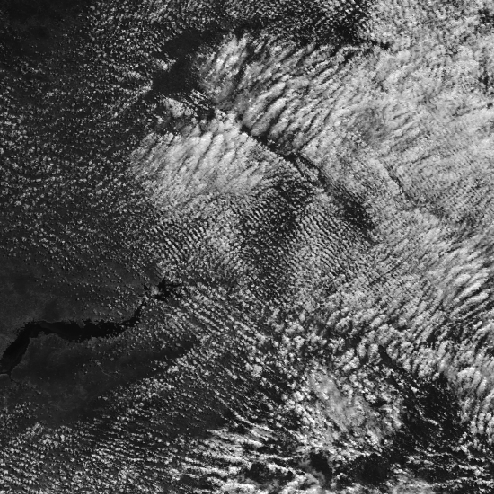

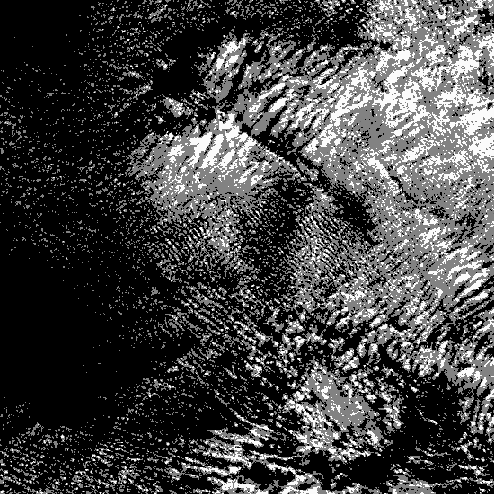

In [52]:
display(img1, img2)